In [1]:
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tutorial_metarl.task import CompositionalTwoArmedBandit
from tutorial_metarl.model import CompositionalTwoArmedAgent as Agent
from tutorial_metarl.utils import compute_stats, to_sqnp
from tutorial_metarl.model.DND import compute_similarities
from tutorial_metarl.model.utils import get_reward, compute_returns, compute_a2c_loss, get_reward_mab, run_agent_inference, one_hot_embedding
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
from tutorial_metarl.trainers import Trainer


sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0 
torch.manual_seed(seed_val)
np.random.seed(seed_val)
torch.cuda.manual_seed(seed_val)

In [2]:
'''init task'''

n_arms = 2
PROBS = [0.1, 0.9] 
n_cues = 1 
ctx_dim = 10
cxt_per_epoch = True
task = CompositionalTwoArmedBandit(probs=PROBS, ctx_dim=ctx_dim, num_arms=n_arms)

In [13]:
'''init model and trainer'''

# DNDLSTM params
dim_hidden = 48
inp_dim =  None # n_arms + 1 + 1 # reward + trial_index
retrieval_dim = 10
inputs = 'context_action_reward'
dim_output = n_arms
estimate_Qvals = True 
dict_len = 1000    
kernel = 'cosine'  # 'l1' or 'l2'
dnd_policy = '1NN' # 'softmax' or '1NN'
unique_keys = True

# training parameters
learning_rate = 1e-3 
n_epochs = 100
n_rounds = 1000
n_trials = 5
beta =  5. # weight for entropy loss
beta_v = 0.05
gamma = 0.8  # 0.8
normalize_return = True

# init agent and optimizer
#agent = Agent(dim_hidden, dim_output, dict_len, input_dim=inp_dim, inputs=inputs, ctx_dim=task.ctx_dim*n_arms, retrieval_dim=retrieval_dim, kernel=kernel, dnd_policy=dnd_policy, unique_keys=unique_keys, q_est=estimate_Qvals)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [14]:
'''train'''

log_return = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_value = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_policy = np.zeros((n_epochs, n_cues, n_rounds))
log_loss_entropy = np.zeros((n_epochs, n_cues, n_rounds))
log_Y = np.zeros((n_epochs, n_cues, n_rounds, n_arms))
log_Y_hat = np.zeros((n_epochs, n_cues, n_rounds, n_trials))
log_regret = np.zeros((n_epochs, n_cues, n_rounds, n_trials))

# loop over epoch
for i in range(n_epochs):
   
    # flush hippocampus which is context and representation
    time_start = time.time()
    agent.reset_memory()
    agent.turn_on_retrieval()

    # for c_indx, cue in enumerate(PROBS):
    # choose structure
    X, Y = task.sample(num_episodes=n_rounds, num_trials=n_trials, cxt_per_epoch=cxt_per_epoch)
    c_indx = 0

    # try different rounds of task
    for m in range(n_rounds): 
       
        # prealloc
        cumulative_reward = 0
        probs, rewards, values, entropys = [], [], [], []
        h_t, c_t = agent.get_init_states()
        a_t = torch.randint(high=n_arms, size=(1,))
        r_t = Y[m][0][a_t].type(torch.FloatTensor).data.reshape(-1)

        # loop over time, for one training example
        for t in range(n_trials):
        
            # only save memory at the end of the last trial
            agent.turn_off_encoding()
            if t == n_trials-1: 
                agent.turn_on_encoding()

            # recurrent computation at time t
            x_t = X[m][t]
            if agent.inputs == 'context_action_reward':
                one_hot_a_t = one_hot_embedding(a_t, n_arms)
                x_t = torch.cat((x_t, one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                                 r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(t).reshape(-1).type(torch.FloatTensor)), dim=0)
            output_t, cache_t = agent(x_t, h_t, c_t)
            a_t, prob_a_t, v_t, h_t, c_t = output_t
            f_t, i_t, o_t, rg_t, m_t, q_t, p_at = cache_t

            prob_t = torch.nn.functional.softmax(q_t.squeeze())
            entropy = -torch.sum(torch.log(prob_t)*prob_t)

            # compute immediate reward
            r_t = get_reward_mab(a_t, Y[m][t])

            # log
            probs.append(prob_a_t)
            rewards.append(r_t)
            entropys.append(entropy)
            values.append(v_t) 
            cumulative_reward += r_t
            log_Y_hat[i, c_indx, m, t] = a_t.item()
            log_regret[i, c_indx, m, t] = 1. - r_t

        returns = compute_returns(rewards, gamma=gamma, normalize=normalize_return)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        loss_entropy = torch.stack(entropys).sum()
        beta_e = np.exp(-(beta*i)/n_epochs)
        loss = loss_policy + beta_v*loss_value - beta_e*loss_entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        #log_Y[i, c_indx] = Y[m] #np.squeeze(Y[m].numpy())
        log_return[i, c_indx, m] = cumulative_reward / n_trials
        log_loss_value[i, c_indx, m] += loss_value.item() / n_trials
        log_loss_policy[i, c_indx, m] += loss_policy.item() / n_trials
        log_loss_entropy[i, c_indx, m] += loss_entropy.item() / n_trials

    # print out some stuff
    time_end = time.time()
    run_time = time_end - time_start
    print(
        'Epoch %3d | return = %.2f | loss: val = %.2f, pol = %.2f, entropy = %.2f | time = %.2f' %
        (i, log_return[i, c_indx, :].mean(), log_loss_value[i, c_indx, m], log_loss_policy[i, c_indx, m], log_loss_entropy[i, c_indx, m], run_time)
    )

<ipython-input-14-de4f6a504620>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_t = torch.nn.functional.softmax(q_t.squeeze())


Epoch   0 | return = 0.73 | loss: val = 0.03, pol = 0.08, entropy = 0.54 | time = 79.85
Epoch   1 | return = 0.61 | loss: val = 0.11, pol = 0.13, entropy = 0.57 | time = 78.28
Epoch   2 | return = 0.59 | loss: val = 0.07, pol = 0.02, entropy = 0.55 | time = 75.91
Epoch   3 | return = 0.60 | loss: val = 0.02, pol = -0.09, entropy = 0.53 | time = 72.79
Epoch   4 | return = 0.60 | loss: val = 0.15, pol = 0.18, entropy = 0.55 | time = 75.17
Epoch   5 | return = 0.61 | loss: val = 0.11, pol = 0.05, entropy = 0.65 | time = 74.52
Epoch   6 | return = 0.61 | loss: val = 0.06, pol = 0.08, entropy = 0.67 | time = 81.33
Epoch   7 | return = 0.61 | loss: val = 0.01, pol = 0.00, entropy = 0.49 | time = 78.84
Epoch   8 | return = 0.62 | loss: val = 0.39, pol = -0.13, entropy = 0.66 | time = 74.66
Epoch   9 | return = 0.64 | loss: val = 0.08, pol = -0.17, entropy = 0.60 | time = 74.33
Epoch  10 | return = 0.65 | loss: val = 0.13, pol = -0.35, entropy = 0.55 | time = 73.26
Epoch  11 | return = 0.64 | 

## save model

In [15]:
model_name = f"agent_compositionaltwoarmedbandits_jwang"
torch.save(agent.state_dict(), model_name + ".pt")

In [16]:
file_name = model_name
np.savez(file_name, n_rounds=n_rounds, n_epochs=n_epochs, n_trials=n_trials, log_Y=log_Y, log_Y_hat=log_Y_hat, log_return=log_return, log_regret=log_regret, log_loss_value=log_loss_value, log_loss_policy=log_loss_policy)

## figures

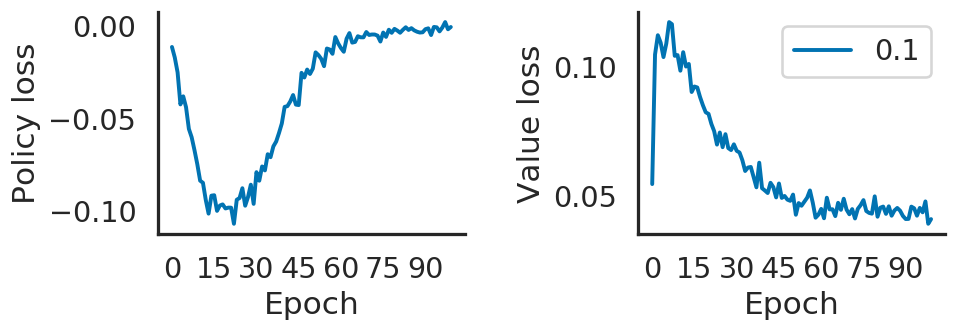

In [17]:
'''loss functions'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_loss_policy.mean(2))
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_ylabel('Policy loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(log_loss_value.mean(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')

plt.legend(PROBS)
sns.despine()
f.tight_layout()

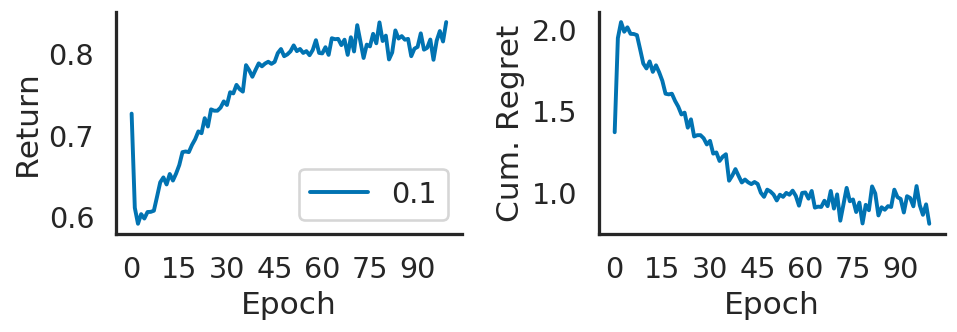

In [18]:
'''learning curves'''

f, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=125)
axes[0].plot(log_return.mean(2)[:n_epochs])
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axes[1].plot(log_regret.cumsum(3).max(3).mean(2))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_ylabel('Cum. Regret')
axes[1].set_xlabel('Epoch')

axes[0].legend(PROBS)
sns.despine()
f.tight_layout()

In [43]:
''' model evaluation for different cues'''

cue = PROBS#[::-1]
n_runs = 10
cxt = 0
X, Y = task._sample_one_episode(torch.cat((task.context[cxt],task.context[200+cxt])), cue, 10) #aa, b, cue, n_runs)
# task.context[cxt], task.arm_per_context[cxt]

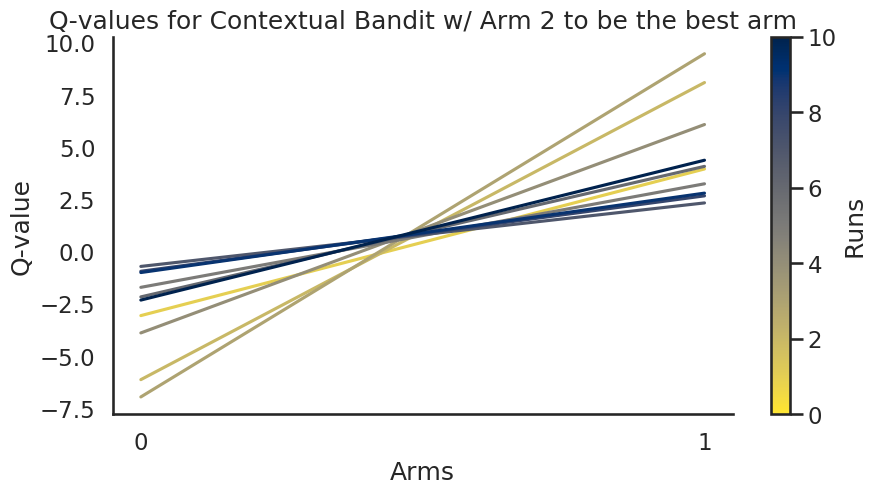

In [44]:
# params
n_cues = len(PROBS)
 
# set up the color scheme
c = np.arange(n_runs+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis_r)
cmap.set_array([])

# run model for n_runs
agent.eval()
agent.turn_on_encoding()
agent.turn_on_retrieval()
#agent.turn_off_encoding()
#agent.turn_off_retrieval()

# set init states
h_t, c_t = agent.get_init_states()
h_t, c_t = torch.zeros_like(h_t), torch.zeros_like(c_t) 
a_t = torch.randint(high=dim_output,size=(1,))
r_t = Y[0][a_t] 
actions, dist, values, temps, regrets = [], [], [], [], []
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

# run model
for t in range(n_runs):
    h_t1 = h_t
    c_t1 = c_t 
    x_t = X[t]
    
    if agent.inputs == 'context_action_reward':
        one_hot_a_t = one_hot_embedding(a_t, n_arms)
        x_t = torch.cat((x_t, one_hot_a_t.reshape(-1).type(torch.FloatTensor), 
                         r_t.reshape(-1).type(torch.FloatTensor), torch.tensor(t).reshape(-1).type(torch.FloatTensor)), dim=0)
    output_t, cache_t = agent(x_t, h_t, c_t)
    a_t, prob_a_t, v_t, h_t, c_t = output_t
    f_t, i_t, o_t, rg_t, m_t, q_t, p_at = cache_t
    a_t = torch.argmax(q_t)
    r_t = Y[t][a_t] 
    
    regrets.append(1. - r_t)
    ax.plot(q_t.detach().numpy().T, c=cmap.to_rgba(t + 1))
    dist.append(torch.sum(F.pairwise_distance(h_t1, h_t, p=2)))
    actions.append(a_t) 
    #values.append(q_t[0][b]) 
    
# format figure
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set(xlabel='Arms',
       ylabel='Q-value',
      title= 'Q-values for Contextual Bandit w/ Arm {} to be the best arm'.format(2))
cbar = plt.colorbar(cmap, ticks=np.arange(n_runs+1, step=n_runs/5), ax=ax)
cbar.set_label('Runs', rotation=90)
sns.despine()
plt.show()

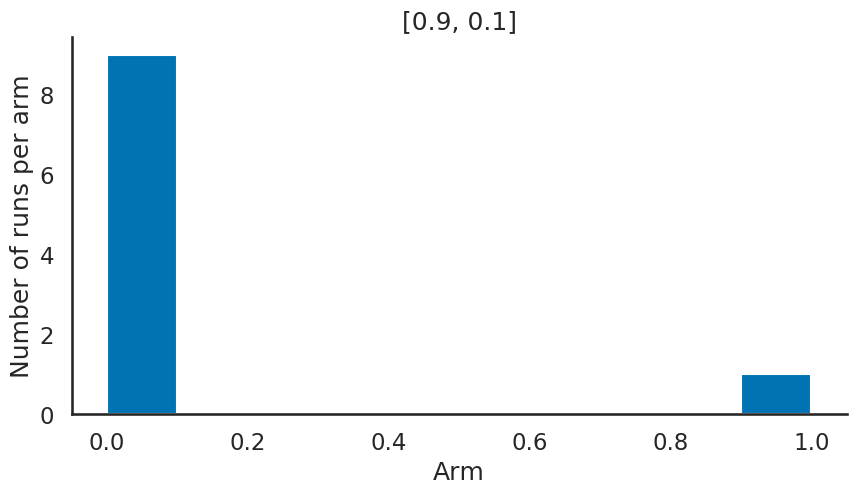

In [42]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
_ = ax.hist(actions)
ax.set(xlabel='Arm',
       ylabel='Number of runs per arm', title = cue)
sns.despine()
plt.show()

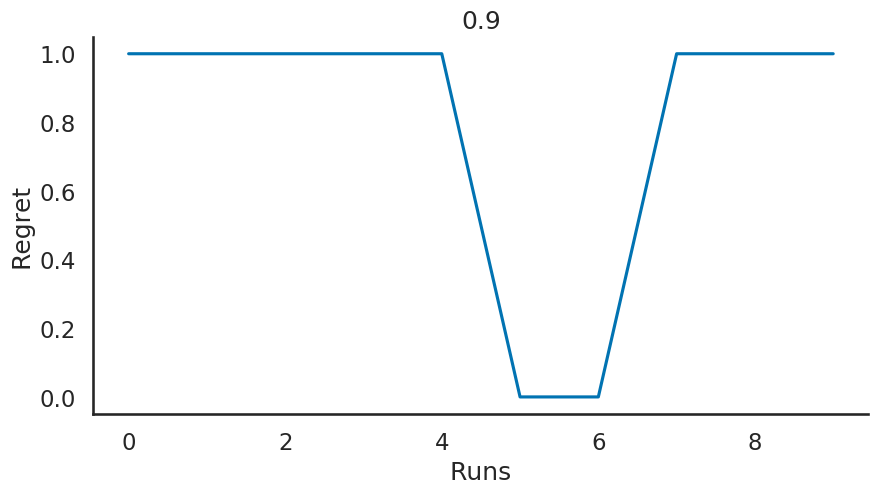

In [61]:
f, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot(regrets)
ax.set(xlabel='Runs',
       ylabel='Regret', title = cue)
sns.despine()
plt.show()